A simpler, more approximate method

In [1]:
import datacube
datacube.config.LocalConfig.db_database = 'wofstest'
datacube.config.LocalConfig.db_hostname = 'agdcstaging-db'
dc = datacube.Datacube()

In [2]:
lon = 143.83756, 143.88605
lat = -30.55194, -30.59073
stack = dc.load(product='wofs_albers', lat=lat, lon=lon)

In [3]:
import numpy as np
stack.water.data &= ~np.uint8(4) # remove ocean masking (optional)

In [4]:
wet = stack.water == 128
dry = stack.water == 0
clear = wet | dry
frequency = wet.sum(dim='time') / clear.sum(dim='time')

/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


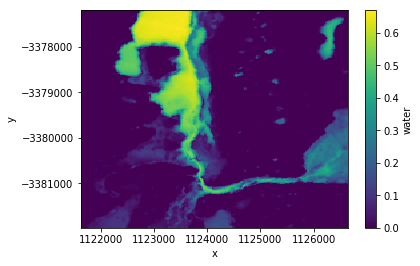

In [5]:
%matplotlib inline
frequency.plot()

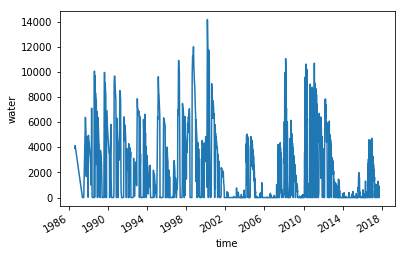

In [6]:
wet.sum(dim=['x','y']).plot()

In [7]:
import matplotlib.pyplot as plt

# Crude data plot
Here, we show how much is wet and how much is dry.

This will only be useful if most observations cover most of the area.

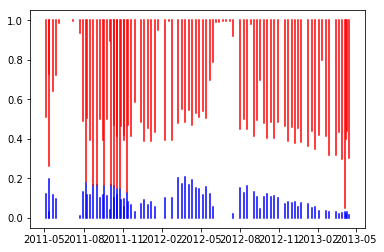

In [8]:
wett, dryy = wet, dry
wett, dryy = wet[1150:1250], dry[1150:1250]

area = np.prod(wet.isel(time=0).data.shape)
obs = wett.time.size
t = wett.time.data
tt = np.vstack([t,t])
w = wett.sum(dim=['x','y']).data / area
d = dryy.sum(dim=['x','y']).data / area
ww = np.vstack([np.zeros(obs), w])
dd = np.vstack([np.ones(obs), 1-d])

n = -1
tt, ww, dd = tt[:,:n], ww[:,:n], dd[:,:n]
plt.plot(tt, ww, c='b')
plt.plot(tt, dd, c='r')
None

# Simplistic errors
Assume no error if bracketed by identical state observations, total error if bracked by unequal states.

0

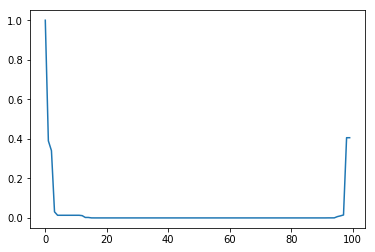

In [9]:
data = (wett.astype(np.int8) - dryy.astype(np.int8)).data
epochs, pixels = data.shape[0], data.shape[1] * data.shape[2]

obs = (data != 0)
pastbound = obs.astype(np.int16).cumsum(axis=0).astype(np.bool)
futurebound = obs[::-1,...].astype(np.int16).cumsum(axis=0).astype(np.bool)[::-1,...]
unbounded = ~(pastbound & futurebound)

plt.plot(unbounded.sum(axis=(1,2)) / pixels)
unbounded[50].sum()

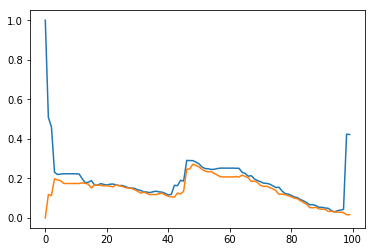

In [10]:
past = data.copy()
future = data.copy()

for i in range(epochs)[1:]:
    hole = (data[i] == 0)    
    past[i][hole] = past[i-1][hole]
    
for i in range(epochs)[::-1][1:]:
    hole = (data[i] == 0)  
    future[i][hole] = future[i+1][hole]
        
upper = (past == 1) | (future == 1) | unbounded
lower = (past == 1) & (future == 1) & ~unbounded

plt.plot(upper.sum(axis=(1,2)) / pixels)
plt.plot(lower.sum(axis=(1,2)) / pixels)
None

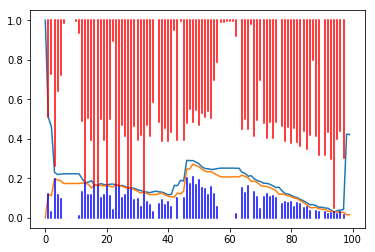

In [11]:
r = np.arange(epochs)
rr = np.vstack([r,r])

plt.plot(upper.sum(axis=(1,2)) / pixels)
plt.plot(lower.sum(axis=(1,2)) / pixels)
plt.plot(rr, ww, c='b')
plt.plot(rr, dd, c='r')
None

Is this claiming to be better than it is?

In [ ]:
interpretive = upper.astype(np.int8)+lower.astype(np.int8)

fig, axes = plt.subplots(1,2)

def draw(i):
    return axes[0].imshow(data[i]), axes[1].imshow(interpretive[i])

import matplotlib as mpl

anim = mpl.animation.ArtistAnimation(fig, [draw(i) for i in range(epochs)])

In [26]:
mpl.rcParams['animation.html'] = 'html5'
anim

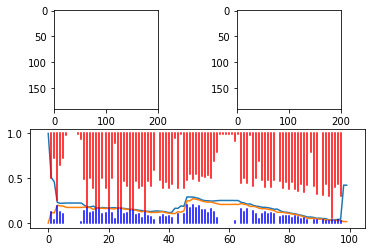

In [87]:
fig = plt.figure() # refresh current figure
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax0 = plt.subplot(212)
#ax0 = plt.subplot(111)

above = upper.sum(axis=(1,2)) / pixels
below = lower.sum(axis=(1,2)) / pixels
ax0.plot(above)
ax0.plot(below)
ax0.plot(rr, ww, c='b')
ax0.plot(rr, dd, c='r')

mid = (above + below) / 2
def draw(i):
    return ax1.imshow(data[i]), ax2.imshow(interpretive[i]), ax0.scatter(r[i], mid[i], c='k', alpha=0.5),

anim = animation.ArtistAnimation(fig, [draw(i) for i in range(epochs)], interval=500)
#anim

In [88]:
anim

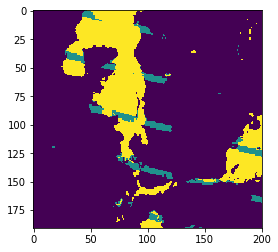

In [94]:
plt.imshow(interpretive[15])

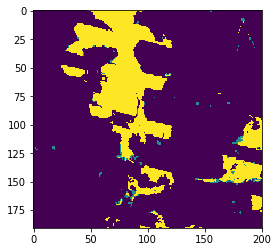

In [96]:
plt.imshow(interpretive[14])

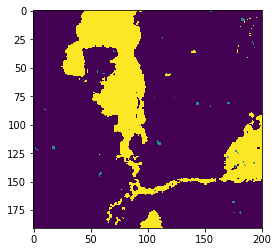

In [97]:
plt.imshow(interpretive[13])

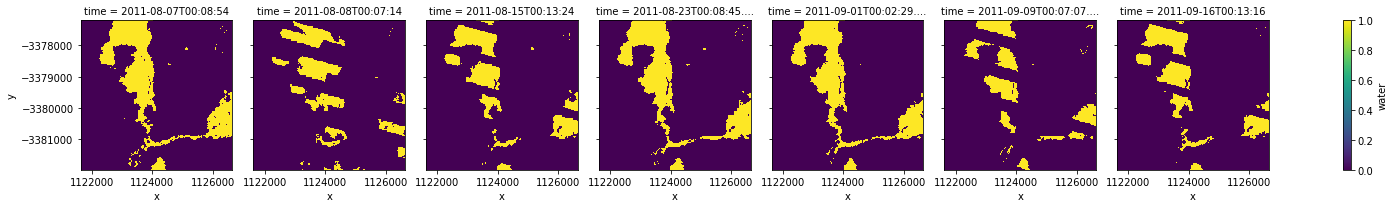

In [103]:
wett.isel(time=slice(13,20)).plot(col='time')

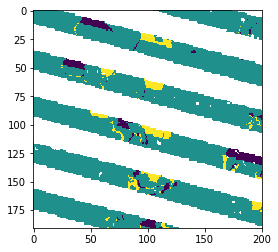

In [112]:
subset = data[13:16].astype(np.float32)
subset[subset == 0] = np.nan
plt.imshow(subset[1] - subset[2])

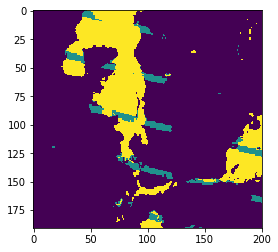

In [115]:
plt.imshow(interpretive[15])

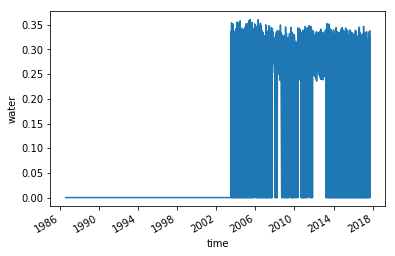

In [119]:
((stack.water & np.uint8(1)).sum(dim=['x','y'])/pixels).plot()